# Using IBM Cloud SQL Query to analyze LogDNA data


**IBM Cloud SQL Query** is IBM's serverless SQL service on data in **Cloud Object Storage**. It allows to run ANSI SQL on Parquet, CSV and JSON data sets. It is based on Apache Spark SQL as the query engine in the background. It can also be used to pre-process and analyze the log archives that LogDNA writes. The below Notebook uses the the Python SDK from IBM Cloud SQL Query. Further details on the Python SDK could be found in  <a href="https://github.com/IBM-Cloud/sql-query-clients/tree/master/Python" target="_blank">Git</a> <br><br>

**LogDNA** is a cloud-based log management software that aggregates all system and application logs in one centralized logging system. LogDNA keeps your logs only for a limited period of time.
However, LogDNA can be configured to **export logs from LogDNA to IBM Cloud Object Storage**. Archived logs are in JSON format and preserve metadata associated with each line. Logs will be exported daily in a compressed format (.json.gz).
<br><br>

This notebook gives an overview on the SQL Query features that help with preparing the log archives for further analysis. Furthermore it shows how to query the logs with SQL to filter out the "noise" in your data.
The start of the notebook shows how to work with your own LogDNA data and the chapter 5 focus on existing ingress sample log data.

## Table of contents
1. [Setup libraries](#setup)<br>
2. [Configure SQL Query](#configure)<br>
3. [Prepare LogDNA dumps for analysis](#prepare)<br>
4. [How to work with SQL Query vs. LogDNA UI](#comparison)<br>
    4.1 [Filtering by sources, apps, levels or tags](#filter)<br>
    4.2 [Field search on parsed fields](#fieldsearch)<br>
    4.3 [Jump to timeframe](#jumptime)<br>
    4.4 [Retrieving schema information](#schema)<br>
5. [Using SQL Query for log analysis](#loganalysis)<br>

### <a id="setup"></a> 1. Setup libraries

Run the following cell at least once in your notebook environment in order to install required packages, such as the SQL Query client library:

In [1]:
!pip -q install ibmcloudsql
!pip -q install sqlparse

In [2]:
import ibmcloudsql
from pixiedust.display import *
import pandas as pd
logDNADump=''
targetUrl=''
logData=''

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table USER_PREFERENCES created successfully
Table service_connections created successfully


### <a id="configure"></a> 2. Configure SQL Query
1. You need an **API key** for an IBM cloud identity that has access to your Cloud Object Storage bucket for writing SQL results and to your SQL Query instance. To create API keys log on to the IBM Cloud console and go to <a href="https://console.bluemix.net/iam/#/apikeys" target="_blank">Manage->Security->Platform API Keys</a>, click the `Create` button, give the key a custom name and click `Create`. In the next dialog click `Show` and copy the key to your clipboard and paste it below in this notebook.
2. You need the **instance CRN** for the SQL Query instance. You can find it in the <a href="https://console.bluemix.net/dashboard/apps" target="_blank">IBM Cloud console dashboard</a>. Make sure you have `All Resources` selected as resource group. In the section `Services` you can see your instances of SQL Query and Cloud Object Storage. Select the instance of SQL Query that you want to use. In the SQL Query dashboard page that opens up you find a section titled **REST API** with a button labelled **Instance CRN**. Click the button to copy the CRN into your clipboard and paste it here into the notebook. If you don't have an SQL Query instance created yet, <a href="https://console.bluemix.net/catalog/services/sql-query" target="_blank">create one</a> first.
3. You need to specify the location on Cloud Object Storage where your **query results** should be written. This comprises three parts of information that you can find in the Cloud Object Storage UI for your instance in the IBM Cloud console. You need to provide it as a **URL** using the format `cos://<endpoint>/<bucket>/[<prefix>]`. You have the option to use the cloud object storage **bucket that is associated with your project**. In this case, execute the following section before you proceed.  
4. You need to specify the location on Cloud Object Storage where your **logDNA objects are stored**. 
5. You need to specify the location on Cloud Object Storage where your pre-processed log data is stored. See below for an example pre-processing query.
<br/>

For more background information, check out the SQL Query <a href="https://console.bluemix.net/docs/services/sql-query/getting-started.html#getting-started-tutorial" target="_blank">documentation</a>.

In [ ]:
import getpass
import sqlparse
from pygments import highlight
from pygments.lexers import get_lexer_by_name
from pygments.formatters import HtmlFormatter, Terminal256Formatter
from IPython.core.display import display, HTML

apikey=getpass.getpass('Enter IBM Cloud API Key (leave empty to use previous one): ') or apikey
instancecrn=input('Enter SQL Query Instance CRN (leave empty to use previous one): ') or instancecrn

sqlClient = ibmcloudsql.SQLQuery(apikey, instancecrn, client_info='SQL Query Starter Notebook')
sqlClient.logon()
print('\nYour SQL Query web console link:')
sqlClient.sql_ui_link()
print('\n')

# Specify where to write write query results:
if targetUrl == '':
    targetUrl=input('Enter target URL for SQL results (like cos://us-south/resultBucket/notebookResults): ')
else:
    targetUrl=input('Enter target URL for SQL results (leave empty to use ' + targetUrl + '): ') or targetUrl

# Specify where the location of logdna dumps:
if logDNADump == '':
    logDNADump=input('Enter URL for LogDNA archive data (like cos://us-south/archiveBucket): ')
else:
    logDNADump=input('Enter URL for LogDNA archive data (leave empty to use ' + logDNADump + '): ') or logDNADump

# Specify where to find the preprocessed log data: 
if logData == '':
    logData=input('Enter URL where to store preprocessed log data (like cos://us-south/preprocessedBucket): ')
else:
    logData = input('\nEnter URL where to store preprocessed log data (leave empty to use ' + logData + '): ') or logData

# For pretty-printing SQL statements
def format_sql(sql):
    formatted_sql = sqlparse.format(sql, reindent=True, indent_tabs=True, keyword_case='upper')
    lexer = get_lexer_by_name("sql", stripall=True)
    formatter = Terminal256Formatter(style='tango')
    return (highlight(formatted_sql, lexer, formatter))

### <a id="prepare"></a> 3. Prepare LogDNA dumps for analysis
You first have to <a href="https://docs.logdna.com/docs/archiving#section-ibm-cloud-object-storage-archiving" target="_blank">configure LogDNA to archive the log files to IBM Cloud Object Store</a>. Once archiving is configured for your account, your logs will be exported on a daily or hourly basis in a compressed format (.json.gz). 

**Note: The following just demonstrates how the preparation of log files would look like sql-wise. You probably want to run this regularly as an automated task on your LogDNA dumps to have the data prepared for log analysis.**

It is possible to query json.gz with SQL Query directly. However, we would not recommend this format as it limits Spark's possibility to process the file in parallel. See <a href="https://www.ibm.com/cloud/blog/big-data-layout" target="_blank">How to Layout Big Data in IBM Cloud Object Storage for Spark SQL</a> for details. 

To improve query performance the data can be partitioned in more manageable junks, for example by hour or application. This allows Spark to skip whole partitions if the respective data is not queried.

In [ ]:
sqlClient.logon()

sql = "SELECT *, " + \
    "date_format(from_unixtime(_source._ts / 1000, 'yyyy-MM-dd HH:mm:ss'), 'yyyy') AS _year, " + \
    "date_format(from_unixtime(_source._ts / 1000, 'yyyy-MM-dd HH:mm:ss'), 'D') AS _dayofyear, " + \
    "date_format(from_unixtime(_source._ts / 1000, 'yyyy-MM-dd HH:mm:ss'), 'HH') AS _hour " + \
    "FROM {} STORED AS JSON " + \
    "INTO {} STORED AS JSON PARTITIONED BY (_year, _dayofyear, _hour)"
sql = sql.format(logDNADump, logData)
print(format_sql(sql))

jobId = sqlClient.submit_sql(sql)
print("SQL query submitted and running in the background. Could take some time depending on the size of your archive data. jobId = " + jobId)
job_status = sqlClient.wait_for_job(jobId)

print("\nJob " + jobId + " finished with status: " + job_status)
if job_status == 'failed':
    details = sqlClient.get_job(jobId)
    print("\nError: {}\nError Message: {}".format(details['error'], details['error_message']))
print("\nResult stored in: " + sqlClient.get_job(jobId)['resultset_location'])

### <a id="comparison"></a> 4. How to work with SQL query compared to LogDNA UI
Now your preprocessed log data is ready for analysis. But before we get started, we give a quick overview on how to work with SQL Query compared to the LogDNA UI to perform tasks that you need for log analysis like filtering or searching log records. 

#### 4.1<a id="filter"></a> Filtering by sources, apps, levels or tags:
 - **LogDNA**: 
 Use the respective drop-down to select one or more sources, apps, log levels or tags.
 <br><br>
 - **SQL Query**: 
 Filter on the respective column. The log record's source, app, log level or tags (if defined) are stored along with the log record also for archived logs.
     - for source:
```sql 
WHERE _source._host IN("source1", "source2")
```
     - for app:
```sql 
WHERE _source._app IN("app1", "app2")
```
    - for level: 
```sql 
WHERE _source.level IN("level1", "level2")
```
    - for tags: You have to explode the tags array before you can query it.
```sql 
WHERE array_contains(_source._tag, "someTag")
```

#### 4.2<a id="fieldsearch"></a> Field search on parsed fields:
  - **LogDNA**:
  In the search input field you enter your search term: 
      - for prefix match on the parsed field (case insensitive): `<name of parsed field>:<some value>` 
      - for term match(case insensitive): `<name of parsed field>:==<some value>`
      - for prefix match on the parsed field (case sensitive): `<name of parsed field>:=<some value>`
      - for term match(case sensitive): `<name of parsed field>:===<some value>`
      - for list of prefix matches (case insensitive): `<name of parsed field>:[value1, value2]`
      - find log records that contain the parsed field, the value doesn't matter: `<name of parsed field>:*`
<br><br>
  - **SQL Query**:
  When archiving the log records all parsed fields are preserved in the log records, so it is possible to query them with SQL Query. You don't have the full-text search capability of LogDNA, however you can work with the LIKE operator and wildcards on specific fields.
      - for prefix match on the parsed field (case sensitive):
```sql 
WHERE _source.nameOfParsedField LIKE "SomeValue%"
```
      - for term match on the parsed field
```sql 
WHERE _source.nameOfParsedField LIKE "%SomeValue%"
```
If in addition case insensitive search is required, the field can be converted to lower case with LOWER(). Make sure to use a lower case search pattern in this case, for example:
```sql 
WHERE LOWER(_source.nameOfParsedField) LIKE "%somevalue%"
```
      - for list of prefix matches:
```sql 
WHERE _source.nameOfParsedField LIKE "value1%" OR _source.nameOfParsedField LIKE "value2%"
```
      - find log records that contain the parsed field, the value doesn't matter:
```sql 
WHERE _source.nameOfParsedField IS NOT NULL
```  

#### 4.3<a id="jumptime"></a> Jump to timeframe: 
  - **LogDNA**: In the Jump to timeframe box you can enter the desired day and time, e.g. today at 11am or a timeframe, e.g. last fri 4:30p to 11/12 1 AM. 
  - **SQL Query**: The LogDNA archived logs contain the field _source._ts which contains a timestamp in milli-second granularity in UTC. Find an example below on how to convert a local datetime string into timestamp that you can use in your query.
  



In [5]:
from datetime import datetime, timezone, timedelta
from dateutil import tz

# For example, we want to convert this date and time string
jumpToTime = "2019-8-17 21:54:55"

# Adjust for your timezone
#input_timezone = tz.gettz('America/New_York')
input_timezone = tz.gettz('Europe/Berlin')


jumpToUTC = datetime.strptime(jumpToTime, '%Y-%m-%d %H:%M:%S')\
    .replace(tzinfo=input_timezone) \
    .astimezone(tz=timezone.utc) 
year = datetime.strftime(jumpToUTC, '%Y')
dayofyear = datetime.strftime(jumpToUTC, '%j')
hour = datetime.strftime(jumpToUTC, '%H')

jumpToTimestamp = jumpToUTC.timestamp() * 1000

print("WHERE _source._ts = {} AND _year = '{}' AND _dayofyear = '{}' AND _hour = {}".format(jumpToTimestamp, year, dayofyear, hour))

WHERE _source._ts = 1566071695000.0 AND _year = '2019' AND _dayofyear = '229' AND _hour = 19


#### 4.4<a id="schema"></a> Retrieving schema information: 

##### 1. Get a list of sources and application names:
LogDNA UI lists the application and sources, that you log data for, in the respective drop-down lists.  
With SQL Query this information can be retrieved as follows:

In [22]:
sqlClient.logon()

sql = "SELECT _source._app AS application , _source._host AS source " + \
    "FROM {} STORED AS JSON " + \
    "GROUP BY application, source " + \
    "ORDER BY application, source " + \
    "INTO {} STORED AS CSV"

sql = sql.format(logData, targetUrl)
print(format_sql(sql))

result_df = sqlClient.run_sql(sql)

if isinstance(result_df, str):
    print(result_df)
    
result_df.head(4)

SELECT _source._app AS application,
	_source._host AS SOURCE
FROM cos://us-geo/sql/LogDNA STORED AS JSON GROUP BY application, source ORDER BY application, source INTO cos://us-south/expire/result STORED AS CSV



,application,source
0,nginx-ingress,public-cr5ff87ab416044e60b8f8b19c1da44ccc-alb1...
1,nginx-ingress,public-cr5ff87ab416044e60b8f8b19c1da44ccc-alb1...
2,nginx-ingress,public-cr5ff87ab416044e60b8f8b19c1da44ccc-alb1...
3,nginx-ingress,public-cr5ff87ab416044e60b8f8b19c1da44ccc-alb1...


##### 2. Retrieve schema information for a specific application:
Schema information is needed to know which fields are available for querying. You can look at the LogDNA UI and expand the respective log line, there you find the field names. <br>
As a general rule:
* fields generated by LogDNA start with a underscore in the archived log records, e.g. \_source, \_app
* fields parsed from log records are passed along as is to the archived logs, e.g. level 
<br>

With SQL Query schema information can be retrieved by using <a href="https://cloud.ibm.com/docs/services/sql-query?topic=sql-query-sql-reference#tableTransformer" target="_blank">DESCRIBE</a>. Running DESCRIBE on the whole log file results in a schema that gives you the fields for all applications. To get a more manageable schema file, first retrieve the logs for the application you are interested in and then run DESCRIBE on it. This returns a JSON object. Then you can switch to the SQL Query UI to view its content. Alternatively you can run <a href="https://cloud.ibm.com/docs/services/sql-query?topic=sql-query-sql-reference#tableTransformer" target="_blank">FLATTEN</a> before DESCRIBE to flatten the nested JSON and then retrieve the result to view in the notebook.  

In [ ]:
sqlClient.logon()

sql = "SELECT * " + \
    "FROM {} STORED AS JSON " + \
    "WHERE _source._app = 'nginx-ingress' AND _source._status IS NOT NULL " + \
    "INTO {} STORED AS JSON"

sql = sql.format(logData, targetUrl)
print(format_sql(sql))

jobid_ingress = sqlClient.submit_sql(sql)
job_status = sqlClient.wait_for_job(jobid_ingress)
if job_status == 'failed':
    details = sqlClient.get_job(jobid_ingress)
    print("Error: {}\nError Message: {}".format(details['error'], details['error_message']))
print("jobId: " + jobid_ingress + "\n")

details = sqlClient.get_job(jobid_ingress)
ingress_records = details['resultset_location']
sql = "SELECT * FROM DESCRIBE(FLATTEN({} STORED AS JSON)) " + \
    "INTO {} STORED AS JSON"

sql = sql.format(ingress_records, targetUrl)
print(format_sql(sql))
jobid_schema = sqlClient.submit_sql(sql)
job_status = sqlClient.wait_for_job(jobid_schema)
if job_status == 'failed':
    details = sqlClient.get_job(jobid_schema)
    print("Error: {}\nError Message: {}".format(details['error'], details['error_message']))

print("jobId: " + jobid_schema)

print('\nUse SQL Query UI to view the results')
sqlClient.sql_ui_link()

In [6]:
print('\nSchema information:')
result_schema = sqlClient.get_result(jobid_schema)
sqlClient.get_result(jobid_schema)


Schema information:


,name,nullable,type
0,_dayofyear,True,long
1,_hour,True,long
2,_year,True,long
3,jobid,True,string
4,_source__app,True,string
5,_source__file,True,string
6,_source__host,True,string
7,_source__lid,True,string
8,_source__logtype,True,string
9,_source__status,True,string


### 5<a id="aggregation"></a> Use SQL query for log analysis
In the following we will use SQL Query to analyze the ingress log records of a test system's kubernetes. First let's retrieve the request counts for each worker node along with the average request time and http status codes.<br>

hint: 
- In the SQL Query UI you get a SQL Editor with syntax highlighting and validation, so it is probably most effective to use the UI to develop a SQL and then copy it over to the notebook.
- You may submit SQL Query jobs to run in the background and then retrieve the results when the job is done. This allows you to continue the work on your notebook while the query is running.
- Storing the job ID in your notebook allows you to retrieve the persisted results without having to rerun the query. 

In [6]:
# Get day of year from date string
from datetime import datetime
dayofyear = datetime.strptime("2019-08-18", '%Y-%m-%d').timetuple().tm_yday
print(dayofyear)

230


In [27]:
sqlClient.logon()
# we switch now to sql query sample preprocessed data for the following queries
logData = 'cos://us-geo/sql/LogDNA'

# targetUrl = 
sql = "SELECT _source._status AS status, COUNT(_source._status) AS status_count, _source.node AS node, " + \
    "AVG(_source.request_time) AS request_time, " + \
    "concat(date_format(from_unixtime(_source._ts / 1000, 'yyyy-MM-dd HH:mm:ss'), 'yyyy-MM-dd'), ' ', _hour, ':00:00') AS _datetime " + \
    "FROM {} STORED AS JSON " + \
    "WHERE _source._app = 'nginx-ingress' AND _source._status IS NOT NULL AND _year = 2019 AND _dayofyear BETWEEN 223 and 230 " + \
    "GROUP BY _year, _dayofyear, _hour, _datetime, _source.node, _source._status " + \
    "INTO {} STORED AS CSV "

sql = sql.format(logData, targetUrl)
print(format_sql(sql))

jobid = sqlClient.submit_sql(sql)
print("jobId: " + jobid)

SELECT _source._status AS status,
	COUNT(_source._status) AS status_count,
	_source.node AS node,
	AVG(_source.request_time) AS request_time,
	concat(date_format(from_unixtime(_source._ts / 1000, 'yyyy-MM-dd HH:mm:ss'), 'yyyy-MM-dd'), ' ', _hour, ':00:00') AS _datetime
FROM cos://us-geo/sql/LogDNA STORED AS JSON WHERE _source._app = 'nginx-ingress' AND _source._status IS NOT NULL AND _year = 2019 AND _dayofyear BETWEEN 223 and 230 GROUP BY _year, _dayofyear, _hour, _datetime, _source.node, _source._status INTO cos://us-south/expire/result STORED AS CSV

jobId: c4a03654-e46e-4de1-814c-dfb411155063


In [28]:
sqlClient.logon()
job_status = sqlClient.wait_for_job(jobid)
if job_status == 'failed':
    details = sqlClient.get_job(jobid)
    print("Error: {}\nError Message: {}".format(details['error'], details['error_message']))

result_df = sqlClient.get_result(jobid)

# Adjust datatypes for Pixiedust
result_df['datetime'] = pd.to_datetime(result_df['_datetime'])
result_df['status'] = result_df['status'].apply(str)
#print(result_df.head())
#print(result_df.info())

Now let's plot the data ...


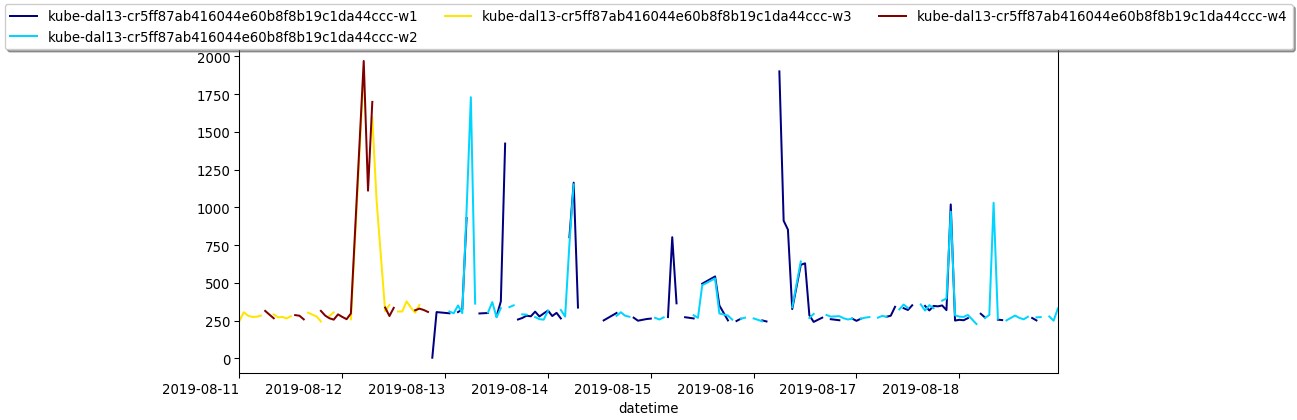

In [ ]:
from pixiedust.display import *
display(result_df)

Ok, that's too many data points. Let's resample the data. I chose 2 data points a day, but you can easily adjust the <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases" target="_blank">freq parameter</a>.


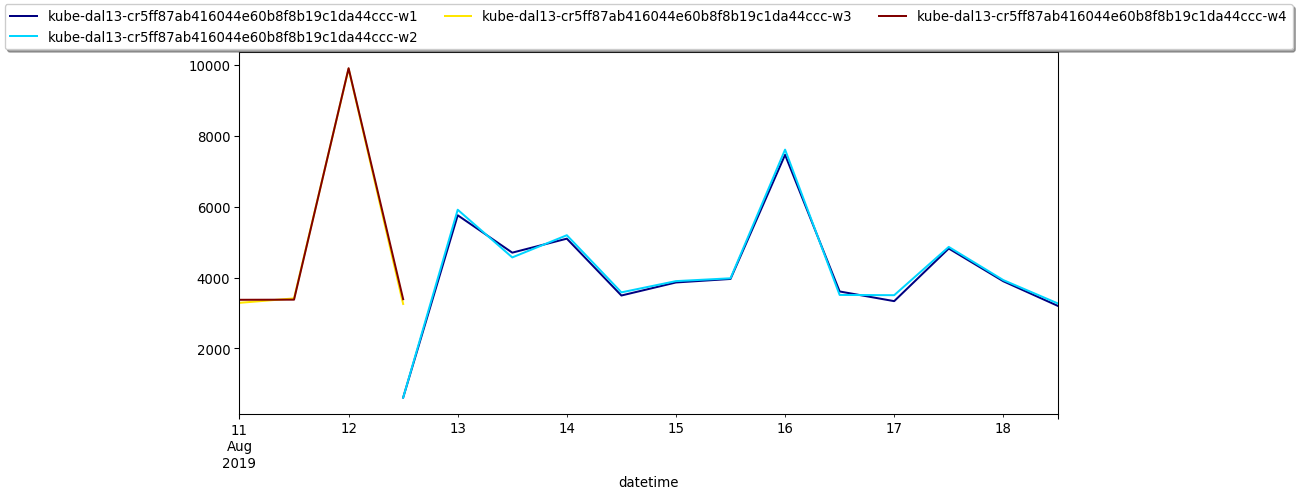

In [30]:
summary = result_df.groupby([pd.Grouper(key='datetime', freq='12H'), 'node', 'status']) \
    .agg({'status_count':'sum', 'request_time': 'mean'}) 
summary.reset_index(inplace=True)
display(summary)

Now, let's look at the HTTP status codes. Here we are probably most interested in failed requests.

In [31]:
daily_summary = result_df.groupby([pd.Grouper(key='datetime', freq='D'), 'node', 'status']) \
    .agg({'status_count':'sum', 'request_time': 'mean'}) 
daily_summary.reset_index(inplace=True)

In [ ]:
display(daily_summary)

On 2019-08-17 we see a lot of server errors (500). To find out more about the failing requests, we retrieve the request URI info. For that we need to make some adjustments to the request URIs to not get flooded with groups, e.g. not found requests can have all sorts of request URIs, so map all of them to INVALID. In our data we use unique jobIds, CRNs or instance IDs as part of our request URIs to request information on these specific artifacts. However, for now we are only interested in the general request type, so we map these as well to a common URI. See the query below.

In [33]:
sqlClient.logon()
# logData =
# targetUrl = 
sql = "SELECT _source._status AS status, " + \
    "COUNT(_source._status) AS status_count, " + \
    "_source.node AS node, " + \
    "CASE " + \
    "WHEN _source.request_uri RLIKE '/v2/sql_jobs/[^\S]+' THEN '/v2/sql_jobs/jobid' " + \
    "WHEN _source.request_uri RLIKE '/active_instance/[^\S]+' THEN '/active_instance/instanceid' " + \
    "WHEN _source.request_uri RLIKE '/v2/service_instances/[^\S]+' THEN '/v2/service_instances/crn' " + \
    "WHEN _source.request_uri RLIKE '/dashboard/[^\S]+' THEN '/dashboard/id' " + \
    "WHEN _source.host = 'pact.ys1-dev-sql-query.us-south.containers.appdomain.cloud' THEN 'PACT' " + \
    "WHEN _source._status = 404 THEN 'INVALID' " + \
    "ELSE _source.request_uri " + \
    "END AS request_uri, " + \
    "AVG(_source.request_time) AS request_time, " + \
    "concat(date_format(from_unixtime(_source._ts / 1000, 'yyyy-MM-dd HH:mm:ss'), 'yyyy-MM-dd'), ' ', _hour, ':00:00') AS _datetime " + \
    "FROM {} STORED AS JSON " + \
    "WHERE _source._app = 'nginx-ingress' AND _source._status IS NOT NULL AND _dayofyear = 229 " + \
    "GROUP BY _year, _dayofyear, _hour, _datetime, _source.node, _source._status, request_uri " + \
    "INTO {} STORED AS CSV"

sql = sql.format(logData, targetUrl)
print(format_sql(sql))
jobid = sqlClient.submit_sql(sql)
print("jobId: " + jobid)

SELECT _source._status AS status,
	COUNT(_source._status) AS status_count,
	_source.node AS node,
	CASE
					WHEN _source.request_uri RLIKE '/v2/sql_jobs/[^\S]+' THEN '/v2/sql_jobs/jobid'
					WHEN _source.request_uri RLIKE '/active_instance/[^\S]+' THEN '/active_instance/instanceid'
					WHEN _source.request_uri RLIKE '/v2/service_instances/[^\S]+' THEN '/v2/service_instances/crn'
					WHEN _source.request_uri RLIKE '/dashboard/[^\S]+' THEN '/dashboard/id'
					WHEN _source.host = 'pact.ys1-dev-sql-query.us-south.containers.appdomain.cloud' THEN 'PACT'
					WHEN _source._status = 404 THEN 'INVALID'
					ELSE _source.request_uri
	END AS request_uri,
	AVG(_source.request_time) AS request_time,
	concat(date_format(from_unixtime(_source._ts / 1000, 'yyyy-MM-dd HH:mm:ss'), 'yyyy-MM-dd'), ' ', _hour, ':00:00') AS _datetime
FROM cos://us-geo/sql/LogDNA STORED AS JSON WHERE _source._app = 'nginx-ingress' AND _source._status IS NOT NULL AND _dayofyear = 229 GROUP BY _year, _dayofyear, _hour, _

In [34]:
sqlClient.logon()
job_status = sqlClient.wait_for_job(jobid)
if job_status == 'failed':
    details = sqlClient.get_job(jobid)
    print("Error: {}\nError Message: {}".format(details['error'], details['error_message']))
resultRange = sqlClient.get_result(jobid)

# Adjust datatypes for Pixiedust
resultRange['datetime'] = pd.to_datetime(resultRange['_datetime'])
resultRange['status'] = resultRange['status'].apply(str)
#print(resultRange.head())
#print(resultRange.info())

In [ ]:
display(resultRange)

So we started to see many 500s at 10am and kept getting them until 9pm. Now we also want to know which request types encountered these 500 errors. 

In [ ]:
display(resultRange)

 So much for that. Now we have a look at the request times.

In [ ]:
display(daily_summary)

These are pretty high response times. However, we retrieved average request times and averages are affected by outliers, especially when probably most response times are sub-second and then you have some that take minutes. So let's just look at the long-running ones.

In [ ]:
display(daily_summary)

So we have about 20 to 120 long-running requests every day returning 101. So for now we take out these requests, to see the average request times for the majority of the requests on the system. And that looks much better, now we see the expected sub-second response times:

In [ ]:
display(daily_summary)

<hr>
Copyright &copy; IBM Corp. 2019. This notebook and its source code are released under the terms of the MIT License.